In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

We will limit our data to the country **USA**:

In [4]:
def dataframeByRegion(df, region):
    return df[df['region'] == region]

In [5]:
spotify_data = pd.read_csv("../data/spotify_2020+_cleaned.csv")
spotify_data["date"] = pd.to_datetime(spotify_data["date"])
us_data = dataframeByRegion(spotify_data, "United States")
us_data.dtypes

Unnamed: 0             int64
title                 object
rank                   int64
date          datetime64[ns]
artist                object
region                object
chart                 object
trend                 object
dtype: object

first, lets check if a song title is aviable both in **top200** and **viral50** charts:

In [6]:
def find_valid_songs(my_data): # returns a list of songs which appear both in top200 and viral50 charts
    data_by_title = my_data.groupby("title")
    usable_titles = []
    for (name,group) in data_by_title.__iter__():
        if ("viral50" in group["chart"].unique() ) and ("top200" in group["chart"].unique()):
            usable_titles.append(name)
    usable_titles = pd.Series(usable_titles)
    num_title = len(us_data["title"].unique())
    print(f" titles which appear in both charts: {usable_titles.count()}\n total number of titles: {num_title}")
    return usable_titles


In [7]:
usable_titles = find_valid_songs(us_data)
usable_title_df = us_data[us_data["title"].isin(usable_titles)]
usable_title_df["title"].count()

 titles which appear in both charts: 747
 total number of titles: 4887


89136

Next, we create two dataframes for our different charts: **Viral50** and **Top200**

In [8]:
viral_50 = usable_title_df[usable_title_df["chart"] == "viral50"]
viral_50.shape

(17114, 8)

In [9]:
viral_50.head()

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961711,10961711,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,United States,viral50,SAME_POSITION
10961713,10961713,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,United States,viral50,SAME_POSITION
10961715,10961715,Blueberry Faygo,3,2020-01-01,Mikey.Otx,United States,viral50,MOVE_UP
10961717,10961717,The Box,4,2020-01-01,Roddy Ricch,United States,viral50,MOVE_DOWN
10961721,10961721,No Idea,6,2020-01-01,Don Toliver,United States,viral50,SAME_POSITION


In [10]:
top_200 = usable_title_df[usable_title_df["chart"] == "top200"]
top_200.shape

(72022, 8)

In order to plot viral rank vs top 200 rank, we need to create a new dataframe:

In [11]:
def get_rank_title_df(titles, viral_50, top_200): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    viral_ranks = []
    top_200_ranks = []
    titles = titles.tolist()
    for my_title in titles:
        viral_rank = viral_50.loc[viral_50["title"] == my_title, ["rank"]].mean()[0]
        viral_ranks.append(viral_rank)
        top_200_rank = top_200.loc[top_200["title"] == my_title, ["rank"]].mean()[0]
        top_200_ranks.append(top_200_rank)
    df = pd.DataFrame(
        {
            "viral_50_rank_mean" : viral_ranks,
            "top_200_rank_mean" : top_200_ranks,
            "title": titles
        }
    )
    return df

In [12]:
rank_title_df = get_rank_title_df(usable_titles, viral_50 = viral_50, top_200 = top_200)
rank_title_df.sample(10)

,viral_50_rank_mean,top_200_rank_mean,title
169,10.951923,113.478261,Do It To It
561,36.571429,101.292683,Still Goin Down
455,32.142857,150.400000,Paradise (feat. Dermot Kennedy)
603,31.285714,81.451163,The Woo (feat. 50 Cent & Roddy Ricch)
362,36.714286,131.750000,Lockdown
352,24.625000,75.515807,Life Is Good (feat. Drake)
433,41.000000,73.000000,On the River (feat. Wiz Khalifa)
608,45.666667,163.000000,This is Halloween - Pop Version
75,32.625000,60.778947,Beautiful Mistakes (feat. Megan Thee Stallion)
516,29.538462,129.428571,Satisfied


## Plotting mean of ranks against each other:
for the entire two years which our spotify data covers

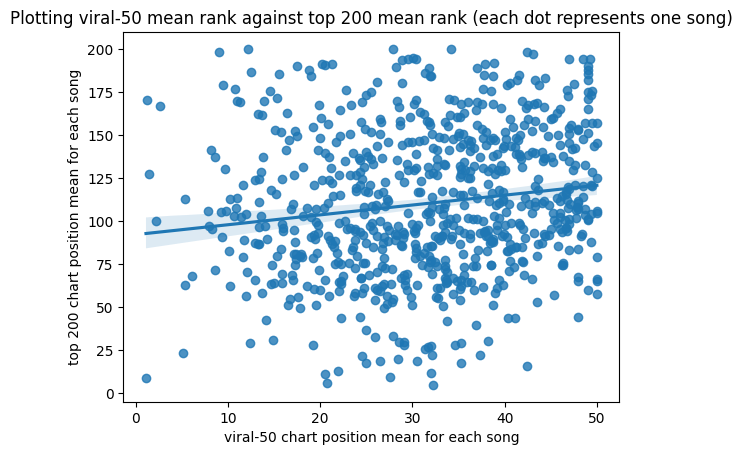

In [13]:
sns.regplot(data=rank_title_df, x = "viral_50_rank_mean", y = "top_200_rank_mean")
plt.title("Plotting viral-50 mean rank against top 200 mean rank (each dot represents one song)")
plt.xlabel("viral-50 chart position mean for each song")
plt.ylabel("top 200 chart position mean for each song")
plt.show()

In [14]:
rank_title_df.corr(method="pearson",numeric_only=True)

,viral_50_rank_mean,top_200_rank_mean
viral_50_rank_mean,1.000000,0.152003
top_200_rank_mean,0.152003,1.000000


As we can see, the viral50 and top 200 ranks are only very weakly correlated. This means that a linear regression model will not suffice to use predict the top200 charts from our viral 50 charts.

## Plotting ranks against each other for selected weeks within our dataframe: 

In [15]:
def get_rank_title_per_week_df(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta) # date of next week
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    for my_title in titles:
        #print(f"list lengths: viral_ranks length: {len(viral_ranks)}\n top_200 length: {len(top_200_ranks)}\n titles length: {len(titles)}")
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        if viral_rank.empty:
            #print(f"Error couldnt retrieve viral50 rank for title {my_title}")
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            if top_200_rank.empty:
                #print(f"Error couldnt retrieve top200 rank for title {my_title}")
                if  len(viral_ranks) > 0:
                    viral_ranks.pop() #fix viral data entry so length is the same
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                title_keys.append(my_title)
                
    df = pd.DataFrame(
        {
            "viral_50_rank" : viral_ranks,
            "top_200_rank" : top_200_ranks,
            "title": title_keys
        }
    )
    return df

In [16]:
dates_to_check = ["2020-01-05", "2020-03-07","2020-08-12", "2021-03-08", "2021-10-29"]
rank_title_week = dict.fromkeys(dates_to_check)
for my_date in dates_to_check:
        rank_title_week[my_date] = get_rank_title_per_week_df(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=my_date, delta=7)


just to be sure, lets do the same plot for one **week**: we check the viral50 charts of the current day and see if they correlate with the top200 charts 7 days later:

/tmp/ipykernel_9974/1334247299.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


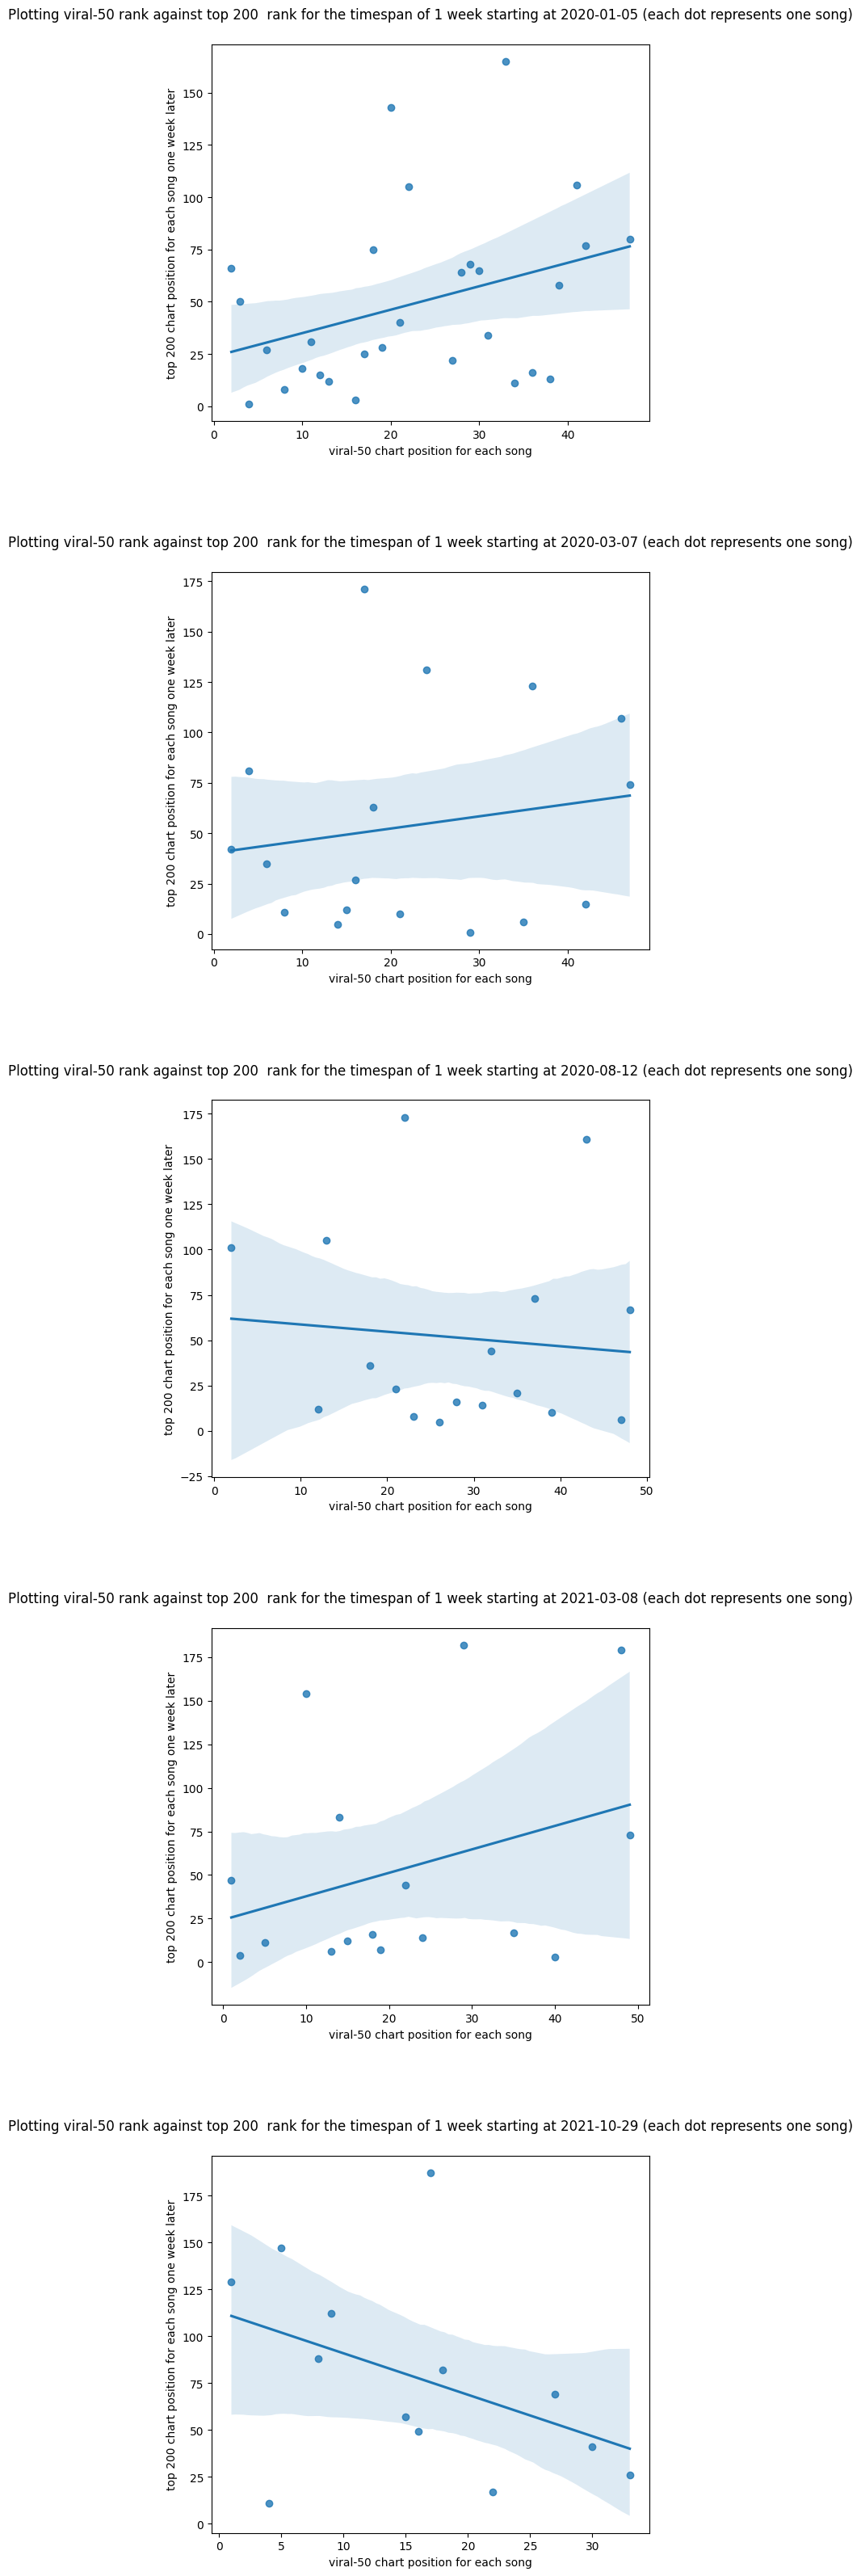

In [17]:
fig, ax = plt.subplots(5,figsize=(7,40))
plt.subplots_adjust(hspace=0.4)
for i, date in enumerate(rank_title_week):
    sns.regplot(data=rank_title_week[date], x = "viral_50_rank", y = "top_200_rank", ax=ax[i])
    ax[i].set_title(f"Plotting viral-50 rank against top 200  rank for the timespan of 1 week starting at {date} (each dot represents one song)",y=1.05)
    ax[i].set_xlabel("viral-50 chart position for each song")
    ax[i].set_ylabel("top 200 chart position for each song one week later")
fig.show()

In [18]:
for my_date, my_df in rank_title_week.items():
    print(f"correlation for week starting at: {date}")
    print(my_df.corr(method="pearson", numeric_only=True))

correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.349135
top_200_rank        0.349135      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.167547
top_200_rank        0.167547      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.094732
top_200_rank       -0.094732      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.320267
top_200_rank        0.320267      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank        1.00000      -0.42335
top_200_rank        -0.42335       1.00000


We can see that depending on which week we pick, the correlation can be very different. This further supports our discovery from the mean plot.
A possible different approach for our final project could be to look at the **change in rank** instead of the rank itself; if a song moves up in rank over a certain period within the viral50 chart, that could indicate a higher rank in the top 200 chart.

In [54]:
def get_trend_title_df(titles, viral_50, top_200): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    viral_trends = []
    top_200_trends = []
    titles = titles.tolist()
    for my_title in titles:
        viral_trend = viral_50.loc[viral_50["title"] == my_title, ["trend"]].mean()[0]
        #print(viral_trend)
        viral_trends.append(viral_trend)
        top_200_trend = top_200.loc[top_200["title"] == my_title, ["trend"]].mean()[0]
        top_200_trends.append(top_200_trend)
    df = pd.DataFrame(
        {
            "viral_50_trend_mean" : viral_trends,
            "top_200_trend_mean" : top_200_trends,
            "title": titles
        }
    )
    return df

In [55]:
viral_50["trend"].unique()

array([0, 1, -1], dtype=object)

In [56]:
def encode_trend(df): # only pass df which have trend column, encodes move up with 1 and move down with -1, everything else 0
    df["trend"] = df["trend"].mask(df["trend"] == "SAME_POSITION", 0)
    df["trend"] = df["trend"].mask(df["trend"] == "NEW_ENTRY", 0)
    df["trend"] = df["trend"].mask(df["trend"] == "MOVE_UP", 1)
    df["trend"] = df["trend"].mask(df["trend"] == "MOVE_DOWN", -1)
    return df

viral_50_trend = encode_trend(viral_50)
top_200_trend = encode_trend(top_200)


/tmp/ipykernel_9974/4084703054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["trend"] = df["trend"].mask(df["trend"] == "SAME_POSITION", 0)
/tmp/ipykernel_9974/4084703054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["trend"] = df["trend"].mask(df["trend"] == "NEW_ENTRY", 0)
/tmp/ipykernel_9974/4084703054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [57]:
trend_df = get_trend_title_df(usable_titles,viral_50=viral_50_trend,top_200=top_200_trend)
trend_df.sample(10)

,viral_50_trend_mean,top_200_trend_mean,title
746,0.047619,0.100418,you broke me first
454,0.428571,0.062500,Paradise
386,-0.333333,-0.857143,Mask
649,-0.142857,-0.500000,Water
91,-0.293333,-0.064171,Body
620,-0.400000,-0.087500,Toosie Slide
640,-0.500000,-0.262295,WHOLE LOTTA MONEY (feat. Nicki Minaj) - Remix
669,-0.485714,-0.125000,Whole Lotta Choppas
561,0.428571,-0.329268,Still Goin Down
510,-0.571429,-0.031646,SO DONE


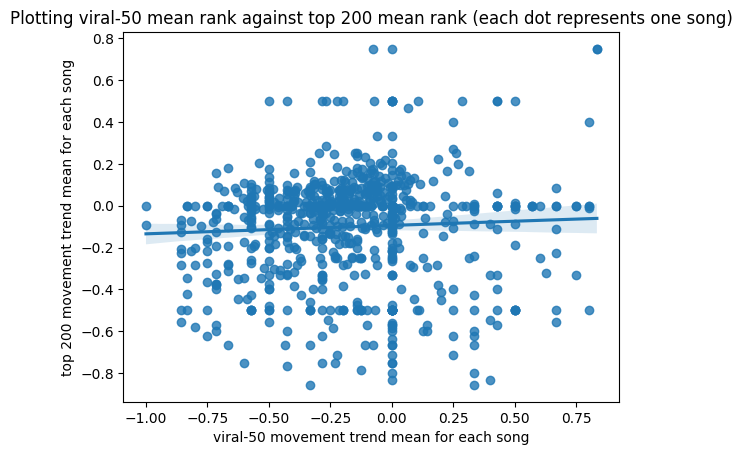

In [58]:
sns.regplot(data=trend_df, x = "viral_50_trend_mean", y = "top_200_trend_mean")
plt.title("Plotting viral-50 mean rank against top 200 mean rank (each dot represents one song)")
plt.xlabel("viral-50 movement trend mean for each song")
plt.ylabel("top 200 movement trend mean for each song")
plt.show()

In [59]:
trend_df.corr(method="pearson")

/tmp/ipykernel_9974/837905897.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  trend_df.corr(method="pearson")


,viral_50_trend_mean,top_200_trend_mean
viral_50_trend_mean,1.000000,0.051971
top_200_trend_mean,0.051971,1.000000


We can see that the trend data is even more weakly correlated